In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
np.set_printoptions(suppress=True)

import numpy as np
import matplotlib.pyplot as plt

def jd_to_date(jd):    
    '''
    Converts Julian date to Gregorian date.
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    import math

    j = jd + 0.5
    z = math.trunc(j)
    f = j - z

    if z < 2299161:
        A = z
    else:
        alpha = int((z - 1867216.25)/36524.25)
        A = z + 1 + alpha - int(alpha/4)

    B = A + 1524
    C = int((B - 122.1)/365.25)
    D = int(365.25 * C)
    E = int((B - D)/30.6001)

    day = B - D - int(30.6001 * E)
    month = E - 1 if E < 14 else E - 13
    year = C - 4716 if month > 2 else C - 4715

    # added by me to calculate hours, minutes, seconds.
    h = int(f * 24)
    m = int((f * 24 - int(h)) * 60)
    s = int((((f * 24 - int(h)) * 60) - m) * 60)

    return year, month, day, h, m, s



def date_to_jd(date, time):    
    '''
    Converts Gregorian date to Julian date given the format:
    date = YYYY-MM-DD, time = HH:MM:SS
    From Astronomical Algorithms, Jean Meeus, 1991.
    '''
    x = time.split(':')
    x = [int(xi) for xi in x]
    s = x[2]
    mi = x[1]
    h = x[0]
    f = h/24 + mi/(60*24) + s/3600
    
    sign = 1
    if date[0] == '-':
        date = date[1:]
        sign = -1
    x = date.split('-')
    x = [int(xi) for xi in x]
    d = x[2]
    mo = x[1]
    y = sign * x[0]
    
    earlyOct1582 = (y==1582 and mo<=10 and d < 15)
    early1582 = (y==1582 and mo<= 9)
    anytimeBefore = (y < 1582)
    
    if earlyOct1582 or early1582 or anytimeBefore:
        flag = 'J'
    else: 
        flag = 'G'

    if mo == 1 or mo == 2:
        y = y - 1
        mo = mo + 12
    
    A = int(y / 100)
    B = 2 - A + int(A / 4) if flag=='G' else 0

    jd = int(365.25 * (y + 4716)) + int(30.6001 * (mo + 1)) + d + B - 1524.5 + f
    
    return jd



def get_moon_phase(now):
    '''
    Calculate moon phase for a given Julian date.(cf. Chapman & Linzen)
    ---INPUT---
        now: a Julian date, including hours, minutes, seconds.
    ---OUTPUT---
        nuHrs: Phase of the moon in hours
    '''
    from math import pi
    
    ref = date_to_jd('1899-12-31', '12:00:00')
    T = (now - ref) / 36525
    nu = -9.26009 + 445267.12165*T + 0.00168*(T**2)
    ageDeg = nu % 360
    nuRad = ageDeg * pi / 180
    nuHrs = (nu/15) % 24
    return nuHrs


def generate_tides(startDate, endDate, amps, phase, dt=1, longIncr=15, 
                   nRange=range(1,3), sRange=range(-6,7), filename='tides.txt',
                   component='solar'):
    '''
    Generates tidal data using the equation:
    A + ΣΣS_{ns}*cos[Ωnt + sλ - Φ_{ns}] + ΣΣL_{ns}*cos[Ωnt + sλ - Φ_{ns}]
    for specified amplitudes and phases. 
    This function is altitude and latitude independent (***???)
    where 
        A = amplitude
        n = 2nd harmonic (semidiurnal variation)
        s = zonal wavenumber (maxes and mins along a line of longitude)
            s = 2 => migrating tide
            s = 3 => non-migrating tide
        t = universal time at Greenwich Meridian
        λ = longitude
        Φ = phase
    --INPUT--
        startDate       a start date, format '2016-06-21'
        endDate         an end date, format '2016-06-30'
        amps            List of amplitude values (length = 3).
        phase           info about whether to vary phase or keep it cosntant
        nRange          values of n to use in calculation
        sRange          values of s to use in calculation
        filename        filename to write values to
        component       solar, lunar, s+l (solar+lunar) or all; specifies 
                        summation bounds for n and s
    --OUTUT--
        Tidal data in array of format:
        Solar local time - Lunar local time - Longitude - Solar Julian date - 
        Lunar Julian date - Hour of day - Moon phase in hours - Tidal value
        
    Adapted from script by Dr. Ruth Lieberman by Eryn Cangi for LASP REU 2016.
    '''
    from math import pi, cos
    
    # VARIABLES --------------------------------------------------------------
    A = amps[0]                    # Background amplitude
    S = amps[1]                    # Solar amplitude
    L = amps[2]                    # Lunar amplitude
    if phase=='C':                 # Phases (Φ_{n,s})
        phi = 0
    else:
        phi = lambda t: cos(t + pi/2)
    hoursPerDay = 24 
     
    # DEFINE LONGITUDE GRID --------------------------------------------------
    numLongs = 360 // longIncr
    longs = np.asarray([l*pi/180 for l in list(range(-180, 180, longIncr))])
    W = 2*pi/24                   # Earth rotation rate (omega)
    
    # GET JULIAN DATES -------------------------------------------------------
    ti = date_to_jd(startDate, '00:00:00')
    tf = date_to_jd(endDate, '00:00:00')
    numDays = int(tf - ti) + 1 # +1 to include the last day in the loops
    
    # MAKE OUTPUT ARRAY ------------------------------------------------------
    rows = numLongs * 24/dt * numDays
    output = np.empty([rows,7])
    r = 0
    
    # LOOP THROUGH TIMESPAN (DAYS) ===========================================
    for day in range(numDays):    # + makes inclusive: calculates for last day
        curJulDate = ti + day
        
        # GET REGULAR DATE FOR CALCULATIONS ----------------------------------
        yr, mo, d, h, minute, sec = jd_to_date(curJulDate) 
        curRegDate = '{}-{:>02}-{:>02}'.format(yr, mo, d)
        curRegHour = h
        
        # LOOP THROUGH HOURS IN DAY ==========================================
        for hr in np.arange(hoursPerDay):
            for f in np.arange(0,1,dt):

                # UPDATE HOUR, GET NEW JULIAN DATE -------------------------------
                curRegHour = 0 + hr
                curRegMin = int(f * 60)
                fracHr = curRegHour + f
                curRegTime = '{:>02}:{:>02}:{:>02}'.format(curRegHour, curRegMin, sec)
                newJD = date_to_jd(curRegDate, curRegTime)

                # GET MOON PHASE AT THIS HOUR ------------------------------------
                nuHrs = get_moon_phase(newJD)

                # LOOP OVER LONGITUDES ===========================================
                for l in longs:
                    # CALCULATE SOLAR LOCAL TIME ---------------------------------
                    slt = fracHr + l/W
                    if slt < 0:            # Wrap around behavior, Earth = sphere
                        slt = slt + 24
                    elif slt > 24:
                        slt = slt - 24
                    else:
                        pass

                    # CALCULATE LUNAR LOCAL TIME ---------------------------------
                    llt = slt - nuHrs
                    llt = llt + 24 if llt < 0 else llt

                    # CALCULATE THE TIDES ----------------------------------------

                    # Assign amplitudes
                    # Background
                    if type(A)==int:
                        tide = A
                    else:
                        tide = A(hr,l)

                    # Solar
                    if type(S)==int:
                        A_S = S
                    else:
                        A_S = S(hr,l)

                    # Lunar
                    if type(L)==int:
                        A_L = L
                    else:
                        A_L = L(hr,l)

                    # Assign phase 
                    if type(phi)==int:
                        p = phi
                    else:
                        p = phi(hr)

                    for n in nRange:
                        for s in sRange:
                            if component=='solar':     # solar contribution
                                # DO NOT CHANGE-----------------------------------
                                tide += A_S * cos((2*pi*n/24)*fracHr + s*l - p)
                                #-------------------------------------------------
                            elif component=='lunar':   # lunar contribution
                                tide += A_L * cos((2*pi*n/24)*(fracHr-nuHrs) + s*l - p)

                            elif component=='s+l':
                                tide += A_S*cos((2*pi*n/24)*fracHr + s*l - p) \
                                      + A_L*cos((2*pi*n/24)*(fracHr-nuHrs) + s*l - p)
                    output[r,0] = slt
                    output[r,1] = llt
                    output[r,2] = round(l * 180/pi)
                    output[r,3] = newJD
                    output[r,4] = fracHr
                    output[r,5] = nuHrs
                    output[r,6] = tide
                    r += 1

    # FORMAT HEADER LINE, WRITE FILE -----------------------------------------
    cells = '{:^20}'*7            
    line0 = cells.format('Solar local time', 'Lunar local time', 'Longitude', 
                        'Julian Date', 'UT', 'Moon phase (hrs)', 'Tide')
    np.savetxt(filename, output, fmt='%.4f', delimiter='\t', header=line0)
    
    return output



def bin_by_solar(data, filename):
    '''
    Finds the mean of the solar contribution at a given solar local time.
    Writes a file of means for each pair of a unique solar local time and
    longitude.
    ---INPUT---
        data        Array of tidal data
        filename    Name for output file
    ---OUTPUT---
        means       3-column array, columns: solar local time, longitude,
                    mean solar contribution.
    '''

    means = []

    # FIND UNIQUE SOLAR LOCAL TIMES ------------------------------------------
    slt = np.ndarray.tolist(data[:,0])
    unique_slt = set([round(x,4) for x in slt])

    # ITERATE OVER SOLAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_slt:
        for lon in range(-180, 180, 15):
            sltSlice = data[np.where(data[:,0] == val)]
            sltSlice = sltSlice[np.where(sltSlice[:,2]==lon)]
            if sltSlice.size != 0:
                means.append([val, lon, np.mean(sltSlice[:,6])])
                
    means = np.asarray(means)

    return means
    

def remove_solar(original, means): 
    '''
    Subtract off the solar tidal averages. Iterates through the file holding 
    solar tidal average data per solar local time and longitude.
    --INPUT--
        original    Data array where columns are solar local time, lunar local
                    time, longitude, lunar Julian date, hour, moon phase and 
                    total tidal value.
        means       Data array containing SLT, longitude and mean tidal value.
    --OUTPUT--
        result      Array holding original data for columns 0-5 and the 
                    "reconstructed" lunar tidal values in column 6
    '''
    
    # create new array to store subtracted values
    #r = np.zeros([original.shape[0]])
    
    # create copy arrays
    solar_to_subtract = np.array(original)
    difference = np.array(original)

    # For each SLT and longitude pair, find row in original data where solar 
    # local time and longitude match. Then subtract the solar tidal data
    for row in means:
        slt = row[0]
        long = row[1]
        avg = row[2]
        # find rows in original data that match
        i = np.where((original[:,0]==slt) & (original[:,2]==long))[0]
        solar_to_subtract[i,6] = avg
        difference[i,6] = original[i,6] - avg
            
    return solar_to_subtract, difference


def chisq(obs, exp):
    '''
    Perform χ² minimization test for the observed and expected lunar tidal 
    data.
    '''
    tot = 0

    for o,e in zip(obs, exp):
        chisq = (o-e)**2 / e
        tot += chisq

    print(tot)


def plot_vs_long(data, date, time, flag, title, c):
    '''
    Plots tidal value versus longitude for a specified Julian date
    ---INPUT---
        data        Array of tidal data
        date        date in format YYYY-MM-DD
        time        time in format HH:MM:SS
        flag        'save' or 'show', controls how the plot is handled.
        title       descriptive plot title
        c           plot line color. Just for aesthetics.
    ---OUTPUT---
        A plot
    '''
    
    
    JDdate = date_to_jd(date, time)

    # FIND ROWS IN DATA ARRAY WITH MATCHING DATE -----------------------------
    # Because data for a particular Julian date is all grouped together, the 
    # values in rows[0] (the indices) will be consecutive.
    rows = np.where(data[:,3]==JDdate)[0]
    i = rows[0]
    f = rows[-1]
    longs = data[i:f,2]
    tides = data[i:f,6]
    
    # PLOT -------------------------------------------------------------------
    plt.figure(figsize=(10,8))
    plt.plot(longs, tides, color=c, marker=r'$\bigodot$', markersize=12)
    plt.title('{}, {} at {}'.format(title, date, time))
    plt.xlabel('Longitude')
    plt.ylabel('Tide amplitude') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    
    if flag=='show':
        plt.show()
        plt.close()
    elif flag=='save':
        fn = 'tides_d{}_{:>02}.png'
        plt.savefig(fn.format(date, time.split(':')[0]), bbox_inches='tight')
        plt.clf()
        plt.close()
    
      
def plot_vs_date(data, long, title, data2=None, c=None, m=None, lb=None, mode='show'):
    '''
    Plots tidal values over time at a particular longitude.
    ---INPUT---
        data        Array of tidal data
        long        Longitude to examine
        title       descriptive plot title
        data2       Optional second data to plot if stacking two tides
        c           color list, has two elements if stacking.
        m           marker shape to use
        lb          Plot legend elements
        mode        Whether to save or show the figure. Default 'show'
    ---OUTPUT---
        A plot
    '''
    
    if data2 != None:
        stack = True
    else: 
        stack = False
        
    # FIND ROWS IN ARRAY WITH MATCHING LONGITUDE -----------------------------
    rows = np.where(data[:,2]==long)[0]
    times = [data[i, 3] for i in rows]
    tides = [data[i, 6] for i in rows]
    
    if stack:
        tides2 = [data2[i,6] for i in rows]
    

    # PLOT -------------------------------------------------------------------
    plt.figure(figsize=(25,6))
    s = len(times)                           # set a limit for plotting
    
    if stack:
        plt.plot(times[:s], tides[:s], color=c[0], marker=m, label=lb[0])
        plt.plot(times[:s], tides2[:s], color=c[1], marker=m, label=lb[1])
        plt.legend(loc='lower right')
    else:
        plt.plot(times, tides, marker=m)
    plt.title('{} by Julian date at {}° Longitude'.format(title, long))
    plt.xlim([min(times),max(times)])
    plt.xlabel('Julian date')
    plt.ylabel('Tide amplitude') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    
    if mode=='show':
        plt.show()
        plt.close()
    elif mode=='save':
        fn = '{} by Julian date at {}° Longitude'.format(title, long)
        plt.savefig(fn, bbox_inches='tight')
        plt.close()
    elif mode=='both':
        fn = '{} by Julian date at {}° Longitude'.format(title, long)
        plt.savefig(fn, bbox_inches='tight')
        plt.show()
        plt.clf()
        plt.close()


def plot_vs_slt(data, time):
    '''
    Plots tidal value versus solar local time
    ---INPUT---
        data        Array of tidal data
        time        time in format HH:MM:SS
    ---OUTPUT---
        A plot
    '''
    
    # FORMAT SLT -------------------------------------------------------------
    time_els = time.split(':')
    time_els = [float(s) for s in time_els]
    time = time_els[0] + time_els[1] / 60 + time_els[2] / 3600

    # CHECK FOR BADLY FORMATTED DECIMALS -------------------------------------
    if time % time_els[0] not in [0, 0.3333, 0.6667]:
        raise Exception('Bad time given')

    # FIND MATCHING SOLAR LOCAL TIMES IN DATA --------------------------------           
    rows = np.where(data[:,0]==time)[0]
    longs = [data[i,2] for i in rows]
    tides = [data[i,6] for i in rows]
    
    # PLOT--------------------------------------------------------------------
    plt.figure(figsize=(10,8))
    plt.scatter(longs,tides, marker='x')
    plt.title('Longitudes vs tides at solar local time {}'.format(time))
    plt.xlabel('Longitude')
    plt.ylabel('Tide value') # what actually is the units of this?
    plt.rcParams.update({'font.size': 16})
    plt.show()
    
    
def bin_by_lunar(data, filename):
    '''
    Finds the mean of the solar contribution at a given solar local time.
    Writes a file of means for each pair of a unique solar local time and
    longitude.
    ---INPUT---
        data        Array of tidal data
        filename    Name for output file
    ---OUTPUT---
        means       3-column array, columns: solar local time, longitude,
                    mean solar contribution.
    '''

    means = []

    # FIND UNIQUE SOLAR LOCAL TIMES ------------------------------------------
    llt = np.ndarray.tolist(data[:,1])
    unique_llt = set([round(x,4) for x in llt])
    print('Unique lunar local times: {}'.format(len(unique_llt)))
    print('Length of lunar local times: {}'.format(len(data[:,1])))

    # ITERATE OVER LUNAR LOCAL TIMES & LONGITUDES ----------------------------
    for val in unique_llt:
        for lon in range(-180, 190, 15):
            lltSlice = data[np.where(data[:,1] == val)]
            lltSlice = lltSlice[np.where(lltSlice[:,2]==lon)]
            if lltSlice.size != 0:
                means.append([val, lon, np.mean(lltSlice[:,6])])
                
    print('Done iterating over LLT...')
    
    means = np.asarray(means)
        
    line0 = 'Lunar Local Time\tLongitude\tMean Lunar Tide'
    np.savetxt('{}_llt_bin.txt'.format(filename), means, fmt='%.4f', delimiter='\t', 
               header=line0)

    return means

# 1 July 2016

So, something weird happened with my previous notebook and I lost all my notes from 30 June afternoon. Luckily I had saved a version of the notebook on github at noon so I recovered much of what was apparently lost (which was 2 days worth). So instead of losing 2 days I only lost a half day. Thankfully.

Lesson learned, though. Will be backing up with git all the time and keeping this notebook a little more basic. I think the notebook extensions may have been causing problems.

So, moving forward, here's what I need to look at.

To do
1. Go through Ruth's no_gaps script and see if I can glean anythng useful from it. 
2. Re-run the comparison plots of SW2 and subtracted, SW2 and averages, original data, etc.
3. Experiment by looking at different time step sizes and longitudes with SW2 only and its average to see if the spikes appear
4. Pick one longitude and universal time and look at the numerical values. Calculate the expectation by hand... see if they make sense

## Various lunar tide plots with different time steps:

<img src="pics/Lunar tides, dt = 12 minutes, by Julian date at -120° Longitude.png" />
<img src="pics/Lunar tides, dt = 15 minutes, by Julian date at -120° Longitude.png" />
<img src="pics/Lunar tides, dt = 60 minutes, by Julian date at -120° Longitude.png" />

## Comparing original solar values to solar subtracted values:

/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:168: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/emc/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:407: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


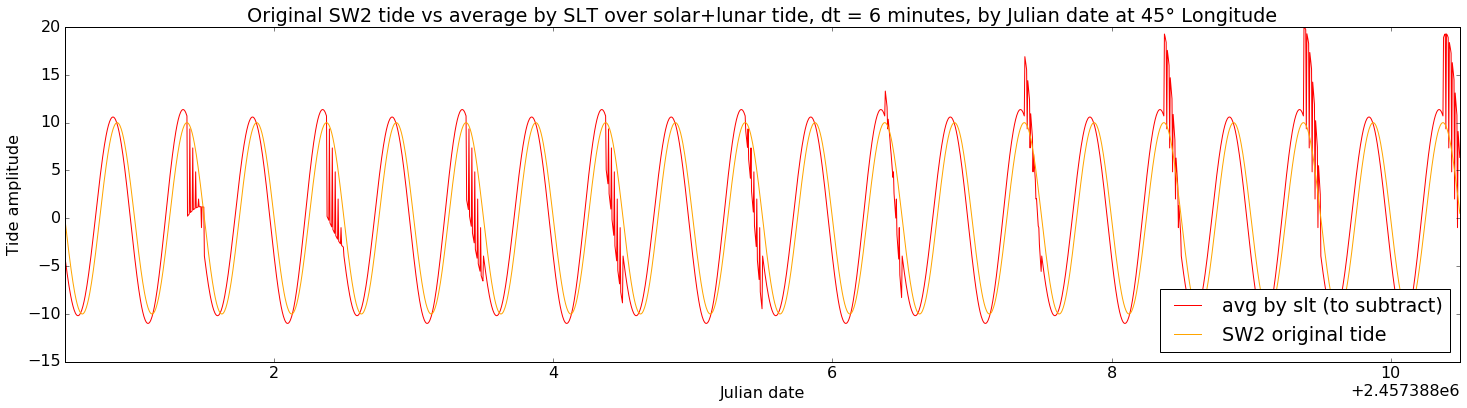

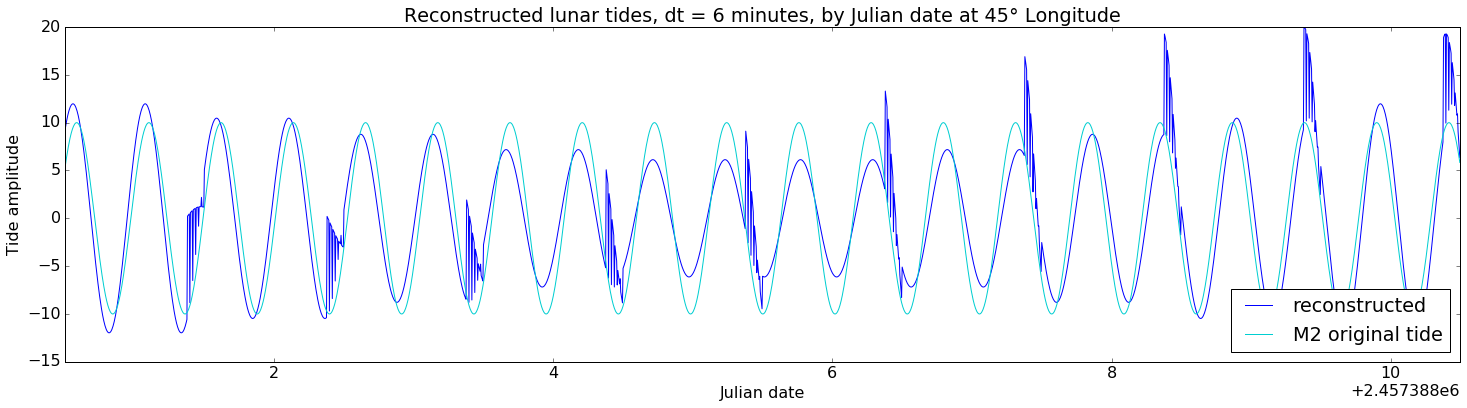

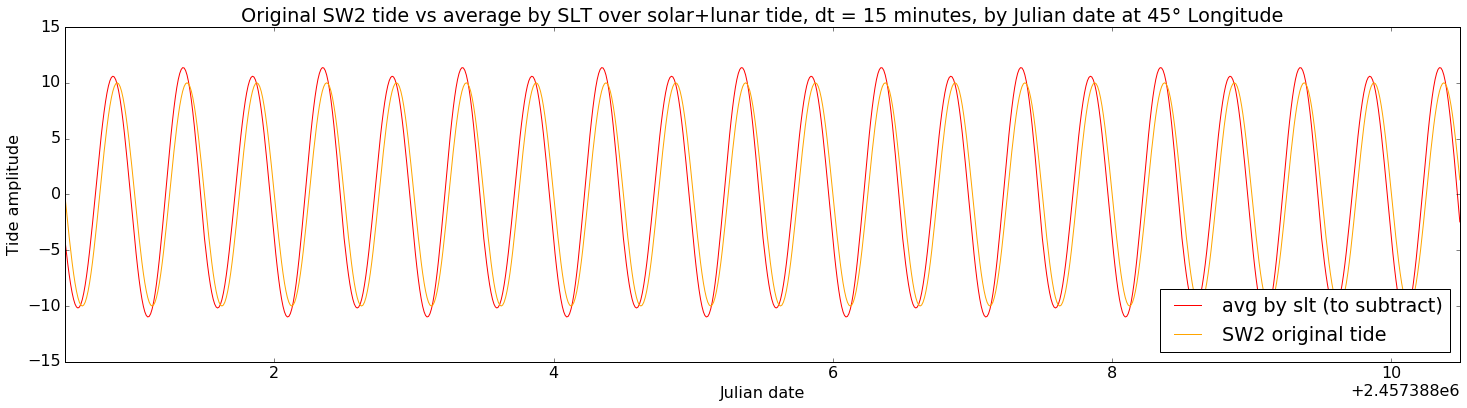

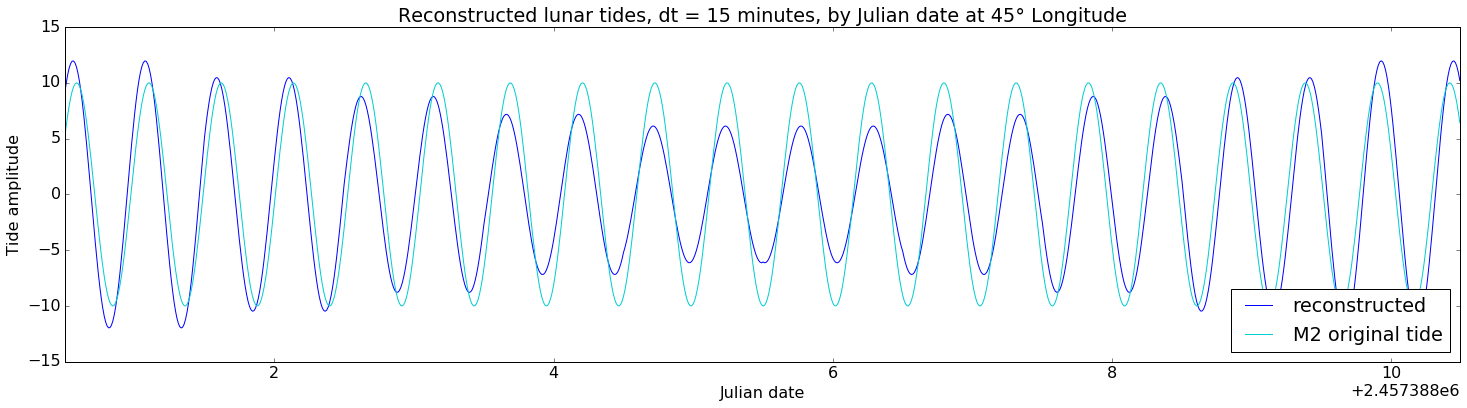

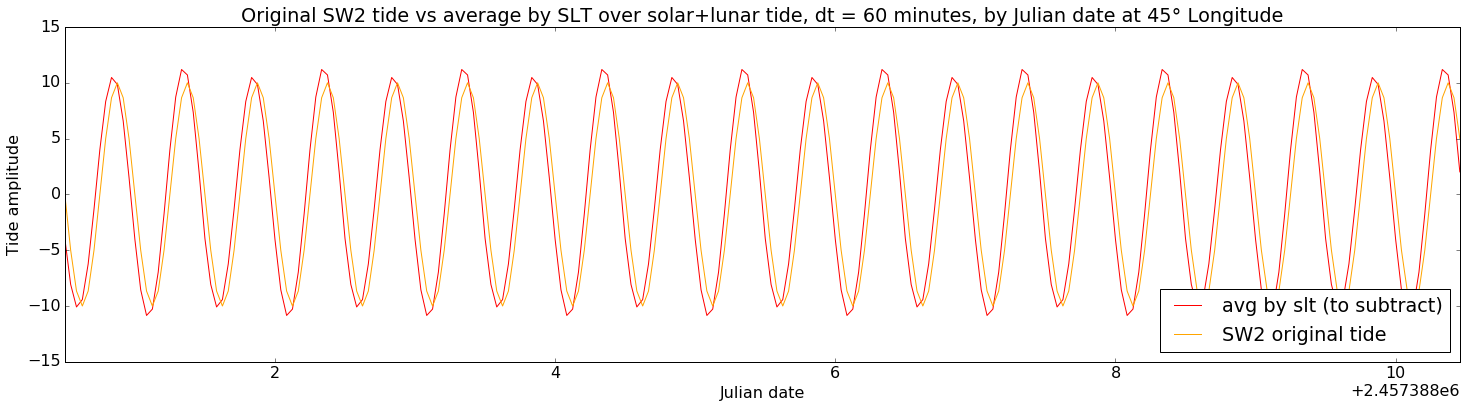

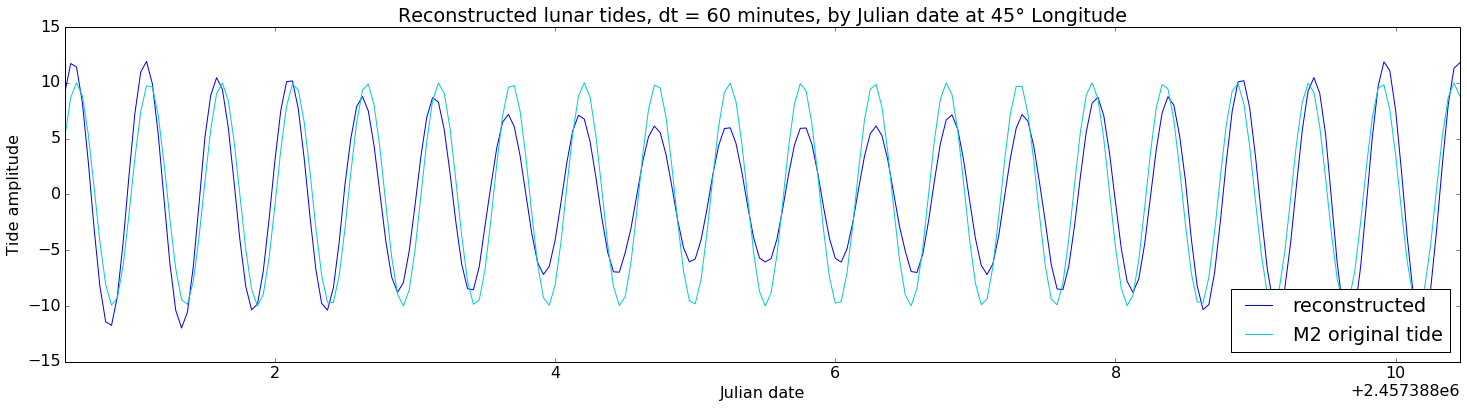

In [5]:
for dt in [0.1, 0.25, 1]:

    #============================================================================#
    # Generate SW2 data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1S = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='SW2_scenario1.txt', 
                            component='solar')

    #============================================================================#
    # Generate M2 data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1L = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='M2_scenario1.txt', 
                            component='lunar')

    #============================================================================#
    # Generate total data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1T = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='TT_scenario1.txt', 
                            component='s+l')

    # Bin by solar local time
    means1T = bin_by_solar(data1T, '1T')

    # Subtract the averages according to solar local time
    subtractedValues, nosol1T = remove_solar(data1T, means1T)

    # Compare input solar to solar averages
    plot_vs_date(subtractedValues, 45, 'Original SW2 tide vs average by SLT over solar+lunar tide, '
                'dt = {} minutes,'.format(int(dt*60)), data2=data1S, 
                c=['red', 'orange'], lb=['avg by slt (to subtract)','SW2 original tide'], 
                mode='show')

    # Compare difference of total and solar averages with lunar
    plot_vs_date(nosol1T, 45, 'Reconstructed lunar tides, '
                'dt = {} minutes,'.format(int(dt*60)), data2=data1L, 
                c=['blue', 'darkturquoise'], lb=['reconstructed','M2 original tide'], 
                mode='show')
    
    print('=============================================================================================')

We expect that the averages above are off because they are computed from data that includes lunar tides. BUT, we don't know why those weird spikes are appearing.

## Compare the solar averages (values to be subtracted) to the original total data:

In [ ]:
for dt in [0.1, 0.25, 1]:

    #============================================================================#
    # Generate SW2 data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1S = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='SW2_scenario1.txt', 
                            component='solar')

    #============================================================================#
    # Generate M2 data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1L = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='M2_scenario1.txt', 
                            component='lunar')

    #============================================================================#
    # Generate total data
    # Background = 0, Constant amplitude and phase
    #============================================================================#
    data1T = generate_tides('2016-01-01', '2016-01-10', amps=[0,10,10], phase='C',
                            dt=dt, nRange=[2], sRange=[2], filename='TT_scenario1.txt', 
                            component='s+l')

    # Bin by solar local time
    means1T = bin_by_solar(data1T, '1T')

    # Subtract the averages according to solar local time
    subtractedValues, nosol1T = remove_solar(data1T, means1T)

    # Compare input solar to solar averages
    plot_vs_date(subtractedValues, 45, 'Original SW2 tide vs average by SLT over solar+lunar tide, '
                'dt = {} minutes,'.format(int(dt*60)), data2=data1T, 
                c=['red', 'orange'], lb=['avg by slt (to subtract)','SW2 original tide'], 
                mode='show')

    # Compare difference of total and solar averages with lunar
    plot_vs_date(nosol1T, 45, 'Reconstructed lunar tides, '
                'dt = {} minutes,'.format(int(dt*60)), data2=data1L, 
                c=['blue', 'darkturquoise'], lb=['reconstructed','M2 original tide'], 
                mode='show')
    
    print('=============================================================================================')

## Check timestep size with SW2 original and its average